In [ ]:
%tensorflow_version 2.x

In [ ]:
import os 
import re 

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from scipy import ndimage, misc
from skimage.transform import resize, rescale
from matplotlib import pyplot

from tensorflow.keras.layers import Input,Dense,Conv2D,MaxPooling2D,Dropout,Conv2DTranspose,UpSampling2D,add
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

np.random.seed(0)

print(tf.__version__)


2.3.0


In [ ]:
%cd /content/drive/MyDrive/ISRP


/content/drive/MyDrive/ISRP


In [ ]:
#!unzip /content/drive/MyDrive/ISRP/cars_train.zip

In [ ]:
input_img = tf.keras.layers.Input(shape=(256, 256, 3))

l1 = tf.keras.layers.Conv2D(64, (3, 3), padding='same',  activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(input_img)
l2 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l1)
l3 = tf.keras.layers.MaxPool2D(padding='same')(l2)

l4 = tf.keras.layers.Conv2D(128, (3, 3), padding='same',  activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l3)
l5 = tf.keras.layers.Conv2D(128, (3, 3), padding='same',  activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l4)
l6 = tf.keras.layers.MaxPool2D(padding='same')(l5)

l7 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l6)

encoder_model = tf.keras.models.Model(inputs=(input_img), outputs=l7)

In [ ]:
encoder_model.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 256, 256, 64)      1792      
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 256, 256, 64)      36928     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 128, 128, 128)     147584    
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 64, 64, 128)      

In [ ]:
input_img = tf.keras.layers.Input(shape=(256, 256, 3))

l1 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(input_img)
l2 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l1)
l3 = tf.keras.layers.MaxPool2D(padding='same')(l2)

l4 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l3)
l5 = tf.keras.layers.Conv2D(128, (3, 3), padding='same',  activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l4)
l6 = tf.keras.layers.MaxPool2D(padding='same')(l5)

l7 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l6)

l8 = tf.keras.layers.UpSampling2D()(l7)
l9 = tf.keras.layers.Conv2D(128, (3, 3), padding='same',  activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l8)
l10 = tf.keras.layers.Conv2D(128, (3, 3), padding='same',  activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l9)

l11 = tf.keras.layers.add([l10, l5])

l12 = tf.keras.layers.UpSampling2D()(l11)
l13 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l12)
l14 = tf.keras.layers.Conv2D(64, (3, 3), padding='same',  activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l13)

l15 = tf.keras.layers.add([l14, l2])

decoded_image = tf.keras.layers.Conv2D(3, (3, 3), padding='same', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l15)

auto_encoder = tf.keras.models.Model(inputs=(input_img), outputs=decoded_image)

In [ ]:
auto_encoder.compile(optimizer='adadelta', loss='mean_squared_error' , metrics=['acc'])

In [ ]:
auto_encoder.summary()

Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_35 (Conv2D)              (None, 256, 256, 64) 1792        input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_36 (Conv2D)              (None, 256, 256, 64) 36928       conv2d_35[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_10 (MaxPooling2D) (None, 128, 128, 64) 0           conv2d_36[0][0]                  
______________________________________________________________________________________

In [ ]:
len(os.listdir('/content/drive/MyDrive/ISRP/cars_train'))

8144

In [ ]:
# test cell for auto best saving model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopper = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=50, verbose=1, mode='min')
model_checkpoint =  ModelCheckpoint('/content/drive/MyDrive/ISRP/superResolution_checkpoint3.h5', save_best_only = True)

In [ ]:
import os
import re
from scipy import ndimage, misc
from skimage.transform import resize, rescale
from matplotlib import pyplot
import numpy as np

def train_batches(just_load_dataset=False):

    batches =  256 # Number of images to have at the same time in a batch

    batch = 0 # Number if images in the current batch (grows over time and then resets for each batch)
    batch_nb = 0 # Batch current index

    max_batches = -1 # If you want to train only on a limited number of images to finish the training even faster.
    
    ep = 1 # Number of epochs

    images = []
    x_train_n = []
    x_train_down = []
    
    x_train_n2 = [] # Resulting high res dataset
    x_train_down2 = [] # Resulting low res dataset
    
    for root, dirnames, filenames in os.walk("/content/drive/MyDrive/ISRP/cars_train"):
        for filename in filenames:
            if re.search("\.(jpg|jpeg|JPEG|png|bmp|tiff)$", filename):
                if batch_nb == max_batches: # If we limit the number of batches, just return earlier
                    return x_train_n2, x_train_down2
                filepath = os.path.join(root, filename)
                image = pyplot.imread(filepath)
                if len(image.shape) > 2:
                        
                    image_resized = resize(image, (256, 256)) # Resize the image so that every image is the same size
                    x_train_n.append(image_resized) # Add this image to the high res dataset
                    rim1 = resize(image_resized, (128, 128))
                    # print(rim1.shape)
                    rimg = resize(rim1, (256, 256))
                    # print(rimg.shape)
                    x_train_down.append(rimg) # Rescale it 0.5x and 2x so that it is a low res image but still has 256x256 resolution
                    batch += 1
                    if batch == batches:
                        batch_nb += 1

                        x_train_n2 = np.array(x_train_n)
                        x_train_down2 = np.array(x_train_down)
                        
                        if just_load_dataset:
                            return x_train_n2, x_train_down2
                        
                        print('Training batch', batch_nb, '(', batches, ')')

                        history = (auto_encoder.fit(x_train_down2, x_train_n2,
                            epochs=ep,
                            batch_size=10,
                            shuffle=True,
                            validation_split=0.15,
                            callbacks=[early_stopper, model_checkpoint]))# this line addes
                    
                        x_train_n = []
                        x_train_down = []
                    
                        batch = 0

    return x_train_n2, x_train_down2

In [ ]:
x_train_n ,x_train_down = train_batches(just_load_dataset=True) 
#True , because we are using pre trained model ! # false if we want to train a model

In [ ]:
#train_acc = history.history['acc']
#val_acc = history.history['val_acc']
#train_loss = history.history['loss']
#val_loss = history.history['val_loss']

In [ ]:
#epochs = range(len(train_acc)) 
#plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
#plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
#plt.title('Training and Validation Accuracy')
#plt.legend()
#plt.figure()
#plt.show()

#plt.plot(epochs, train_loss, 'b', label='Training Loss')
#plt.plot(epochs, val_loss, 'r', label='Validation Loss')
#plt.title('Training and Validation Loss')
#plt.legend()
#plt.show()

In [ ]:
#not-using#autoencoder.load_weights('/content/drive/MyDrive/ISRP/sr.img_net.mse_hfenn.final_model5_2.no_patch.weights.best.hdf5')
auto_encoder.load_weights('/content/drive/MyDrive/ISRP/b-20-echos-4b.h5')

#auto_encoder.save_weights('a.h5')
#auto_encoder.save_weights('/content/drive/MyDrive/ISRP/b-10-echos-4b.h5')


In [ ]:
#encoded_imgs = encoder_model.predict(x_train_down)
#encoded_imgs.shape
#sr1 = np.clip(auto_encoder.predict(x_train_down), 0.0, 1.0)
#image_index = np.random.randint( 0 , 256)

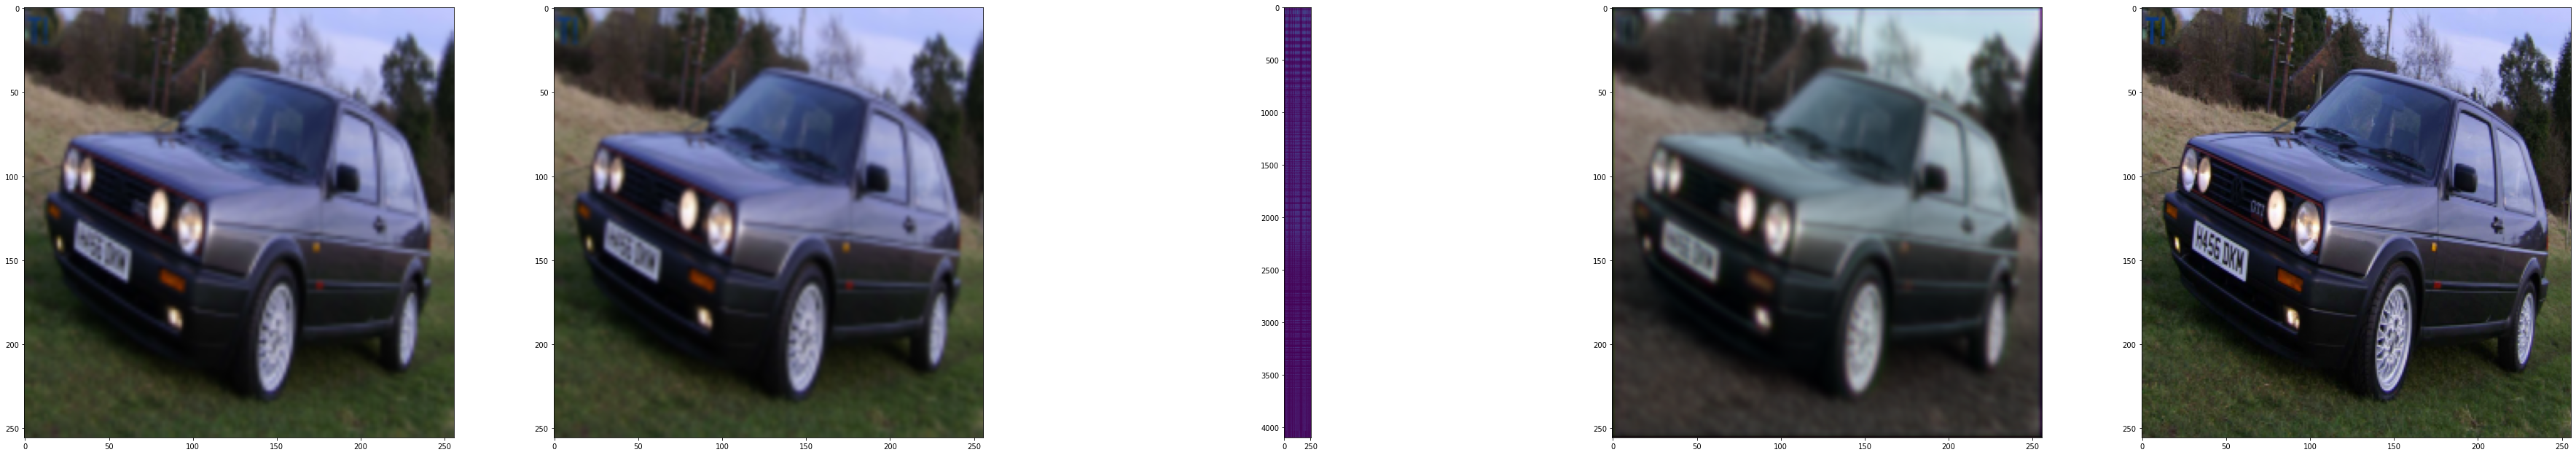

In [ ]:
encoded_imgs = encoder_model.predict(x_train_down)
encoded_imgs.shape
sr1 = np.clip(auto_encoder.predict(x_train_down), 0.0, 1.0)
image_index = np.random.randint( 0 , 256)



plt.figure(figsize=(128, 128))
i = 1
ax = plt.subplot(10, 10, i)
plt.imshow(x_train_down[image_index])
i += 1
ax = plt.subplot(10, 10, i)
plt.imshow(x_train_down[image_index], interpolation="bicubic")
i += 1
ax = plt.subplot(10, 10, i)
plt.imshow(encoded_imgs[image_index].reshape((64*64, 256)))
i += 1
ax = plt.subplot(10, 10, i)
plt.imshow(sr1[image_index])
i += 1
ax = plt.subplot(10, 10, i)
plt.imshow(x_train_n[image_index])
plt.show()
